In [6]:
#import gpu
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
# Lib for preprocessing
from PIL import Image
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Lib for model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout


print("Done")

Done


In [10]:
folder_training = r"/kaggle/input/brain2/brain/Training"
Path = []
Labels = []

#to get the path for each Img :

folders_path = os.listdir(folder_training)
for img in folders_path :
    FolderPath = os.path.join(folder_training, img)
    FolderName = os.listdir(FolderPath)
    for path in FolderName :
        Images_path = os.path.join(FolderPath, path)

        Path.append(Images_path)
        Labels.append(img)

# to creat DataFrame
Pseries = pd.Series(Path, name = "Img_Path")
Lseries = pd.Series(Labels, name = "Img_label")
df_train = pd.concat([Pseries, Lseries], axis=1)

In [11]:
df_train

,Img_Path,Img_label
0,/kaggle/input/brain2/brain/Training/pituitary/...,pituitary
1,/kaggle/input/brain2/brain/Training/pituitary/...,pituitary
2,/kaggle/input/brain2/brain/Training/pituitary/...,pituitary
3,/kaggle/input/brain2/brain/Training/pituitary/...,pituitary
4,/kaggle/input/brain2/brain/Training/pituitary/...,pituitary
...,...,...
5707,/kaggle/input/brain2/brain/Training/glioma/Tr-...,glioma
5708,/kaggle/input/brain2/brain/Training/glioma/Tr-...,glioma
5709,/kaggle/input/brain2/brain/Training/glioma/Tr-...,glioma
5710,/kaggle/input/brain2/brain/Training/glioma/Tr-...,glioma


In [12]:
folder_test = r"/kaggle/input/brain2/brain/Testing"
Path = []
Labels = []

# To get the path for each image in the test set:

folders_path = os.listdir(folder_test)  # Use folder_test here
for img in folders_path:
    FolderPath = os.path.join(folder_test, img)  # Use folder_test here
    FolderName = os.listdir(FolderPath)
    for path in FolderName:
        Images_path = os.path.join(FolderPath, path)

        Path.append(Images_path)
        Labels.append(img)

# To create DataFrame
Pseries = pd.Series(Path, name = "Img_Path")
Lseries = pd.Series(Labels, name = "Img_label")
df_test = pd.concat([Pseries, Lseries], axis=1)

In [13]:
df_test

,Img_Path,Img_label
0,/kaggle/input/brain2/brain/Testing/pituitary/T...,pituitary
1,/kaggle/input/brain2/brain/Testing/pituitary/T...,pituitary
2,/kaggle/input/brain2/brain/Testing/pituitary/T...,pituitary
3,/kaggle/input/brain2/brain/Testing/pituitary/T...,pituitary
4,/kaggle/input/brain2/brain/Testing/pituitary/T...,pituitary
...,...,...
1306,/kaggle/input/brain2/brain/Testing/glioma/Te-g...,glioma
1307,/kaggle/input/brain2/brain/Testing/glioma/Te-g...,glioma
1308,/kaggle/input/brain2/brain/Testing/glioma/Te-g...,glioma
1309,/kaggle/input/brain2/brain/Testing/glioma/Te-g...,glioma


In [14]:
valid_df, test_df = train_test_split(df_test, train_size=0.5, shuffle= True, random_state=42)

In [15]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_generator = tr_gen.flow_from_dataframe(
    df_train,
    x_col='Img_Path',  # Use the correct column name for file paths
    y_col='Img_label', # Use the correct column name for labels
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_generator = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='Img_Path',  # Use the correct column name for file paths
    y_col='Img_label', # Use the correct column name for labels
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_generator = ts_gen.flow_from_dataframe(
    df_test,
    x_col='Img_Path',  # Use the correct column name for file paths
    y_col='Img_label', # Use the correct column name for labels
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


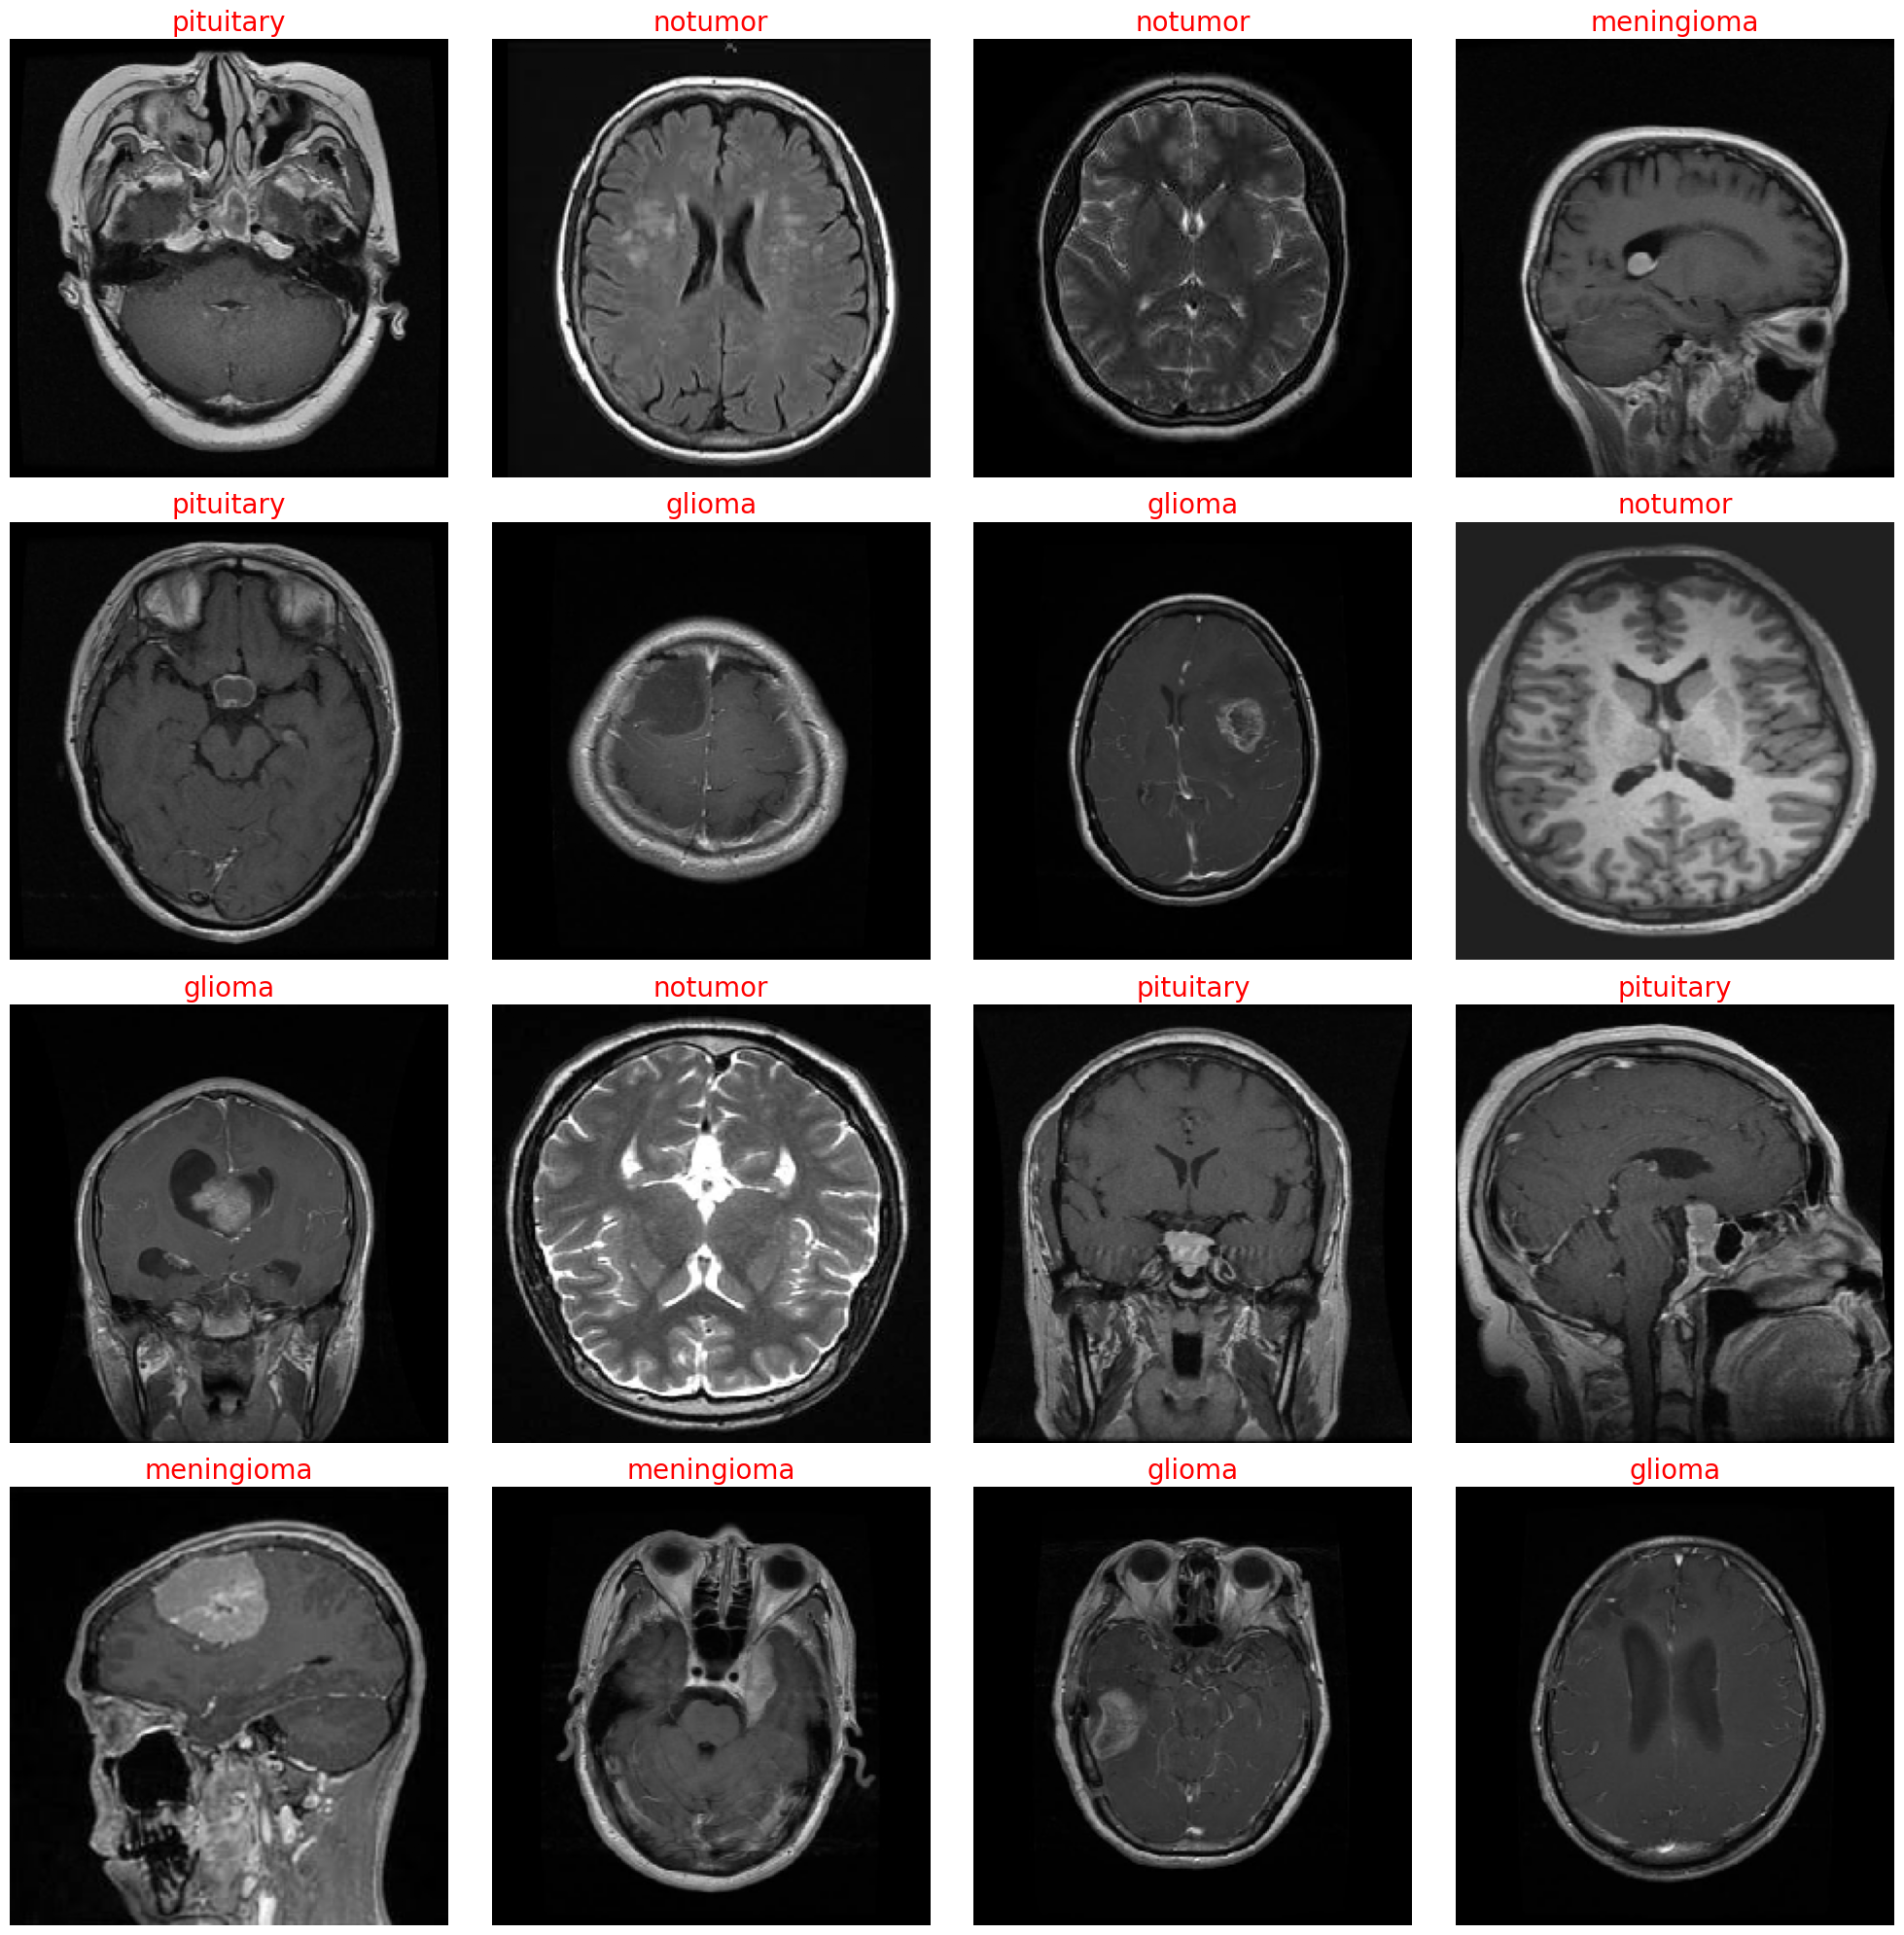

In [16]:
# Dictionary mapping class names to indices
gen_dict = train_generator.class_indices
# List of class names
classes = list(gen_dict.keys())

# Fetch a batch of images and labels
images, labels = next(train_generator)

# Set up the figure size
plt.figure(figsize=(20, 20))

# Loop through the first 20 images in the batch
for i in range(16):
    plt.subplot(4, 4, i + 1)

    # Normalize image pixel values to [0, 1] range
    image = images[i] / 255.0

    # Display the image
    plt.imshow(image)

    # Get the class index and class name
    index = np.argmax(labels[i])  # Get image index
    class_name = classes[index]   # Get class of image

    # Set the title with class name
    plt.title(class_name, color='red', fontsize=20)
    plt.axis('off')

# Adjust layout for better spacing between plots
plt.tight_layout()
# Display the plot
plt.show()


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import DenseNet201  # Update to DenseNet201

# Load DenseNet201 model without the top layers
base_model = DenseNet201(weights='/kaggle/input/dense201/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top of DenseNet201
x = base_model.output
x = Flatten()(x)  # Flatten the output from the DenseNet model
x = Dense(256, activation='relu')(x)  # Fully connected layer with 256 units
predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 classes

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 42,407,748 (161.77 MB)

 Trainable params: 42,178,692 (160.90 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [19]:
epochs =  10  # number of all epochs in training

history = model.fit(train_generator, epochs= epochs, verbose= 1, validation_data= valid_generator, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 4075s 11s/step - accuracy: 0.6154 - loss: 4.0517 - val_accuracy: 0.7695 - val_loss: 0.7864
Epoch 2/10
 70/357 ━━━━━━━━━━━━━━━━━━━━ 49:35 10s/step - accuracy: 0.8598 - loss: 0.4745

KeyboardInterrupt: 

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(valid_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

In [ ]:
# Generate the class labels
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Compute the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap='Reds')  # Use red colormap
plt.title('Confusion Matrix')
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names= classes))

In [ ]:
#Save the model
model.save('Brain_Tumors_Classifier_densenet201.h5')

In [ ]:
#Save the model
model.save('Brain_Tumors_Classifier_densenet201.h5')

In [ ]:
model.save('Brain_Tumors_Classifier_densenet201.keras')

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/Shareddrives/MUKESH_NO_PROJECT/SAVED MODELS/Brain_Tumors_Classifier_densenet.h5', compile=False)
loaded_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Image path
from google.colab import files
uploaded = files.upload()

# Get the filename of the uploaded image

image_path = next(iter(uploaded))
image = Image.open(image_path)

# Preprocess the image before prediction
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Print the predicted class
predicted_class = class_labels[np.argmax(predictions)]
print(predicted_class)

In [ ]:
# Example using VGG16
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(new_class_count, activation='softmax')(x) # new_class_count is the number of classes in your combined dataset

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Example using VGG16
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
new_class_count = 4 # Replace with the actual number of classes in your dataset
predictions = Dense(new_class_count, activation='softmax')(x) # new_class_count is the number of classes in your combined dataset

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Import required libraries for Grad-CAM
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras import backend as K
from PIL import Image

from google.colab import files
uploaded = files.upload()


# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/your_shared_drive_path/Brain_Tumors_Classifier.h5', compile=False)
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

# Load an example image
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path)
img = img.resize((224, 224))
img_array = np.array(img)

# Preprocess the image
input_img = np.expand_dims(img_array, axis=0)
input_img = preprocess_input(input_img)

# Make predictions
predictions = model.predict(input_img)
predicted_class = np.argmax(predictions[0])
print(f'Predicted class: {predicted_class}')

# Define a function to get the Grad-CAM
def get_gradcam_heatmap(model, img_array, layer_name, class_idx):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Get the heatmap
last_conv_layer_name = 'block5_conv3'  # Adjust this depending on your model
heatmap = get_gradcam_heatmap(model, input_img, last_conv_layer_name, predicted_class)

# Display the heatmap on the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img_array)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap with red color
plt.title('Tumor Detection with Grad-CAM')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from tensorflow.keras import backend as K

# Load the model architecture and weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Ensure this matches the number of classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Load the trained model weights
model.load_weights('/content/drive/MyDrive/your_shared_drive_path/Brain_Tumors_Classifier.h5')

# Load and preprocess the image
uploaded = files.upload()
image_path = next(iter(uploaded))
img = Image.open(image_path)
img = img.resize((224, 224))
img_array = np.array(img)

input_img = np.expand_dims(img_array, axis=0)
input_img = preprocess_input(input_img)

# Make predictions
predictions = model.predict(input_img)
predicted_class = np.argmax(predictions[0])
print(f'Predicted class: {predicted_class}')

# Function to get Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, layer_name, class_idx):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Get the heatmap
last_conv_layer_name = 'block5_conv3'  # Adjust this depending on your model
heatmap = get_gradcam_heatmap(model, input_img, last_conv_layer_name, predicted_class)

# Display the heatmap on the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img_array)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap with red color
plt.title('Tumor Detection with Grad-CAM')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from PIL import Image
from google.colab import files

# Upload an image file
uploaded = files.upload()

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/your_shared_drive_path/Brain_Tumors_Classifier.h5', compile=False)
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

# Load an example image
image_path = next(iter(uploaded))
img = Image.open(image_path)
img = img.resize((224, 224))
img_array = np.array(img)

# Preprocess the image
input_img = np.expand_dims(img_array, axis=0)
input_img = tf.keras.applications.vgg16.preprocess_input(input_img)

# Make predictions
predictions = model.predict(input_img)
predicted_class = np.argmax(predictions[0])
print(f'Predicted class: {predicted_class}')

# Ensure the model has been called at least once before creating the Grad-CAM
_ = model(input_img)

# Function to find the last Conv2D layer in the model
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

# Define a function to get the Grad-CAM
def get_gradcam_heatmap(model, img_array, layer_name, class_idx):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Get the last convolutional layer name
last_conv_layer_name = get_last_conv_layer(model)

# Get the heatmap
heatmap = get_gradcam_heatmap(model, input_img, last_conv_layer_name, predicted_class)

# Display the heatmap on the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_array)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img_array)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap with red color
plt.title('Tumor Detection with Grad-CAM')
plt.show()


-----------------------------------------------------------------------

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from tensorflow.keras import backend as K

# Define the model architecture
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Ensure this matches the number of classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Load the trained model weights
model.load_weights('/content/drive/MyDrive/your_shared_drive_path/Brain_Tumors_Classifier.h5')


In [ ]:
jupyter nbconvert --to html /Downloads/Classification.ipynb
